# Data Generation for Hybrid CNN

In [ ]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3

In [ ]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.autonotebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg
from gis_utils import raster
import matplotlib.pyplot as plt
import fiona
import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Image Generation Functions


In [ ]:
def write_ndvi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    nir = p_img.read(4)
    array = p_img.read()
    ndvi = (nir - red)/(nir + red)
    show(ndvi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndvi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [ ]:
def write_ndwi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    green = p_img.read(2)
    nir = p_img.read(4)
    array = p_img.read()
    ndwi = (green - nir)/(nir + green)
    show(ndwi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndwi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [ ]:
def write_vari(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    green = p_img.read(2)
    blue = p_img.read(3)
    array = p_img.read()
    vari = (green - red)/(green + red - blue)
    show(vari)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(vari, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [ ]:
#getting features from the gdf for rasterio
from os.path import join

def getFeatures(gdf):

    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
          

In [ ]:
#for creating corresponding HR tiles from LR pixels
def transfer_tiles(img, meta, tile_path, output_path):
    out_meta = meta
    output_filename = 'hr_{}.tif'
    d_bbox = box(img.bounds.left, img.bounds.bottom, img.bounds.right, img.bounds.top)

    for root, dirs, files in os.walk(tile_path):
        for file in tqdm(files):
            name = os.path.splitext(file)[0]
            dataset, _ = raster.load_image(join(root,file))
            bounds = dataset.bounds
            bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

            if bbox.within(d_bbox):
                geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
                geo = geo.to_crs(crs=dataset.crs.data)
                coords = getFeatures(geo)
                out_img, out_transform = mask(img, shapes=coords, crop=True)
                out_meta.update({"driver": "GTiff","height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": from_epsg(4326)})
                outpath = os.path.join(output_path, output_filename.format(name))
                with rasterio.open(outpath, 'w', **out_meta) as outds:
                    outds.write(out_img)
            

In [ ]:
#for removing tiles created 
def remove_zero(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, meta = raster.load_image(filepath)
        if np.array_equal(np.unique(np.array(tile.read())), [0.]):
            os.remove(filepath)

# Workflow Functions

In [ ]:
#Function for getting files needed for data generation process from the drive

from os.path import join

def get_filelist():
    cur = []
    dest = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/"

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
        for file in files:
            
            #finding all normal tifs
            if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("kompsat" in file) or ("planetscope" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
                
                #detecting planetscope images
                for ortho in os.listdir(root):
                    if ("planetscope" in ortho):
                        
                        folder = [name for name in os.listdir(root) if ("classifications" in name)]
                        if folder == []:
                            continue
                        
                        zero = "0.shp"
                        one = "1.shp"

                        if not(os.path.isfile(join(root,folder[0],zero))) and not(os.path.isfile(join(root, folder[0],one))):
                            dest_zip = join(dest,os.path.splitext(file)[0] + ".zip")
                            #since we will get dupicates
                            file_list = [join(root,file),
                                            join(root,ortho),
                                            dest_zip]
                            if not(file_list in cur) and not(os.path.isfile(dest_zip)):
                                cur.append(file_list)
                                    



    return cur

In [ ]:
# for copying files over from google drive to 
def copy_files(file_list):
    print("Copying Files")

    !cp {"\"" + file_list[0] + "\"" } .
    !cp {"\"" + file_list[1] + "\"" } .

    d_name = os.path.basename(file_list[0])
    p_name = os.path.basename(file_list[1])

    !mv {d_name} /content/drone.tif
    !mv {p_name} /content/planetscope.tif

    !rm -rf /content/lr
    !rm -rf /content/hr 
    !mkdir lr
    !mkdir hr

In [ ]:
def retile(file_list):
    print("Clipping and pixelizing satellite data")

    !gdal_retile.py -ps 1 1 -targetDir "/content/lr" "planetscope.tif"
    
    remove_zero("/content/lr/")


In [ ]:
def gen_drone(file_list):
    print("Generating Satellite Data and Uploading")

    d_img, d_meta = raster.load_image("/content/drone.tif")
    
    transfer_tiles(d_img, d_meta, "/content/lr", "/content/hr")


In [ ]:
from tempfile import mkdtemp
from skimage.transform import resize
from os.path import basename, dirname
from rasterio.plot import reshape_as_image
import glob


def load_images(image_dir):
    hr_name = join(mkdtemp(), 'hr.memmap')
    lr_name = join(mkdtemp(), 'lr.memmap')

    num_images = len(glob.glob1("/content/hr","*.tif"))
    hr_mem = np.memmap(hr_name, dtype='float32', mode='w+', shape=(int(num_images),85,85,3))
    lr_mem = np.memmap(lr_name, dtype='float32', mode='w+', shape=(int(num_images),5))

    index = 0
    file_list = []

    for root, dirs, files in os.walk(image_dir):
        for file in tqdm(files):
            if (file.endswith(".tif")):
                file_path = os.path.join(root, file)
                file_list.append(file_path)

                lr_file = file.replace("hr_", "")
                lr_root = root.replace("hr", "lr")
                lr_path = join(lr_root,lr_file)

                hr_image, _ = raster.load_image(file_path)
                lr_image, _ = raster.load_image(lr_path)

                hr_mem[index,:,:,:] = resize(reshape_as_image(hr_image.read()), (85,85,3))
                lr_mem[index,:] = np.squeeze(np.squeeze(reshape_as_image(lr_image.read())))
                index += 1
    
    return hr_mem, lr_mem, file_list

In [ ]:

def clean_tiles(image_dir):
    num = 0

    for root, dirs, files in os.walk(image_dir):
        for file in tqdm(files):
            if (file.endswith(".tif")):
                file_path = os.path.join(root, file)
                hr_image, _ = raster.load_image(file_path)
                if np.array_equal(np.unique(hr_image.read()), [0]):
                    lr_file = file.replace("hr_", "")
                    lr_root = root.replace("hr", "lr")
                    lr_path = join(lr_root,lr_file)
                    os.remove(file_path)
                    os.remove(lr_path)
                    num += 1
            
    print(num)

In [ ]:
def classify(model, files, hr, lr):
    predictions = model.predict([lr,hr], batch_size=32)
    print(predictions)
    column_names = ["prediction","p_0","p_1","filename"]
    result_df = pd.DataFrame(columns=column_names)


    #associate filenames and classification for each prediction
    for i,prediction in tqdm(enumerate(predictions)):
        result_df.loc[i,"filename"] = files[i]

        #calculating predictions 
        result_df.loc[i,"p_0"] = prediction[0]
        result_df.loc[i,"p_1"] = prediction[1]
        
        #getting final class prediction
        result_df.loc[i,"prediction"] = np.argmax(prediction)
    return result_df

In [ ]:
def move_files(result_df):
    image_directory = "/content/hr/"

    dest_folders = []
    #Organize tiles into folders
    for index, row in tqdm(result_df.iterrows()):
        cur_file = row['filename']
        classification = row['prediction'] 

        #set destination folder, and creates the folder if it doesn't exist
        dest_folder = os.path.join(os.path.abspath(image_directory),str(classification))
        dest_folders.append(dest_folder)
        if os.path.exists(dest_folder) == False:
            os.mkdir(dest_folder)
        dest = os.path.join(dest_folder,os.path.basename(cur_file))
    
        #moves file
        src = cur_file
        os.rename(src, dest)

In [ ]:
from rasterio.merge import merge

def merge_raster(input_files, output_file):
    images = []
    #get files from file list and load the rasters
    for file in input_files:
        image, meta = raster.load_image(file)
        images.append(image)

    #merge all the rasters together
    array, transform = merge(images)

    #set meta of merged file to the same as the original 
    out_meta = meta.copy()

    #edit meta for merged raster
    out_meta.update({"driver": "GTiff",
                                           "height": array.shape[1],
                                           "width": array.shape[2],
                                           "transform": transform}
                                          )
    
    #write merged raster
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(array)

In [ ]:
from os.path import join

#for returning full path of file instead of local path for listdir
def listpath(dir):
    path_list = []
    for file in os.listdir(dir):
        path_list.append(join(dir,file))
    return path_list


Generating data for:  /content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2020 Misc Flights/Puerto Gata/lap_202004_PuertoGata_ortho.tif
Copying Files


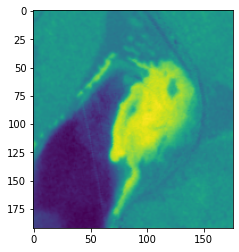

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Satellite Data and Uploading


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[5.3728947e-21 1.0000000e+00]
 [1.7785378e-20 1.0000000e+00]
 [1.3854974e-19 1.0000000e+00]
 ...
 [0.0000000e+00 1.0000000e+00]
 [1.0184067e-20 1.0000000e+00]
 [9.8356679e-03 4.7974643e-01]]


In [ ]:
from tensorflow.keras.models import load_model


sites = get_filelist()
site = sites[4]

print("Generating data for: ", site[0])

copy_files(site)

write_ndvi("planetscope.tif")
#write_vari("planetscope.tif")
#write_ndwi("planetscope.tif")

retile(site)
gen_drone(site)

hr, lr, files = load_images("/content/hr")

model = load_model("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Models/Hybrid CNN/efficientnetb0")
results_df = classify(model, files, hr, lr)

!rm -rf 0 1
!mkdir 0 1


move_files(results_df)

one_files = listpath("/content/hr/1/")
merge_raster(one_files, output_file="1.tif")

zero_files = listpath("/content/hr/0/")
merge_raster(zero_files, output_file="0.tif")